In [ ]:
!pip install torch transformers conllu unidecode pandas numpy datasets evaluate colorama seaborn

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
base_path = 'gdrive/MyDrive/NLP_Projects/lexical_resources'
lang = 'maltese'



Mounted at /content/gdrive


In [3]:
!ls 

gdrive	sample_data


In [4]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Change dirs

Key to change directories for imports of modules and facilitates file import

In [5]:

%cd gdrive/MyDrive/NLP_Projects/lexical_resources  

/content/gdrive/.shortcut-targets-by-id/13KkCD2fkNEO2nduVuPwn1HhOMzKANE0K/lexical_resources


In [32]:
import numpy as np
from dataclasses import dataclass
from tqdm import tqdm
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import Dataset
import pandas as pd
import seaborn as sns
import conllu
from unidecode import unidecode
import matplotlib.pyplot as plt
from utils.dataloader import PreDataCollator
from utils.utils import *

In [7]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


In [8]:
# tokenizer = PreTrainedTokenizerFast.from_pretrained("MLRS/mBERTu")  # AutoTokenizerFast
# model = AutoModelForTokenClassification.from_pretrained("MLRS/mBERTu")  # AutoModelForTokenClassification
model_name = "bert-base-multilingual-cased"
model_name = "bert-base-multilingual-cased"
#model_name = f"./Languages/{lang}/outputs/{model_name}-{lang}"
model_name = f"./Languages/{lang}/outputs/MLRS/mBERTu-{lang}/Final"
model_name = f"MLRS/mBERTu"

tokenizer = AutoTokenizer.from_pretrained(model_name)  # AutoTokenizerFast

# pre_trained_bert = BertModel.from_pretrained("/content/gdrive/Shared drives/NLP Project/saved_model_far/maltese_pretrain")
# pre_trained_tokenizer = BertTokenizer.from_pretrained("/content/gdrive/Shared drives/NLP Project/saved_token/maltese-validation-tokenizer")

# Offset mapping

Example of masking and why it works

In [ ]:
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    
encoding = tokenizer(['Il-', 'Membru', 'tal-', 'Kumitat'], is_split_into_words=True, return_offsets_mapping=True, padding='max_length', truncation=True, max_length=512)  # using it for aligning
print(encoding.keys())
tokenizer.convert_ids_to_tokens(encoding['input_ids'])
encoded_tags = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
encoded_tags
print(tokenizer.convert_ids_to_tokens(encoding['input_ids']))
print(encoding['offset_mapping'])
for idx, mapping in enumerate(encoding['offset_mapping']):
  if mapping[0] == 0 and mapping[1] != 0:
    print(idx)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping'])
['[CLS]', 'Il', '-', 'Mem', '##bru', 'tal', '-', 'Ku', '##mita', '##t', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[P

# Helper functions

In [9]:
def get_tag_mappings(unique_tags):
    """
    It creates a dictionary that maps each tag to a unique integer, and another dictionary that maps
    each unique integer to a tag
    :return: A dictionary of tags to ids and a dictionary of ids to tags.
    """    
    
    tags_to_ids = {k: v for v, k in enumerate(unique_tags)}
    ids_to_tags = {v: k for v, k in enumerate(unique_tags)}

    return tags_to_ids, ids_to_tags


In [10]:
import re

def sentence_generator(tokens, spaces):
    sentences = []
    for sent, space in zip(tokens, spaces):  
      join_sent = sent[0]
      for tok, status in zip(sent[1:], space):
        if status:
            if 'SpaceAfter' in status.keys():  #  sometimes this can be conj?
              
              if status['SpaceAfter'] == 'No':
                  join_sent += tok
              else:
                  join_sent += (' ' + tok)
            else:
                join_sent += (' ' + tok)
        else:
            join_sent += (' ' + tok)
      sentences.append(join_sent)     
    return sentences

def read_conllu(file):
    """
    file: conllu format file
    returns: sentences and upostags per sentence
    """
    corpus = open(file, "r", encoding="utf-8")
    data = conllu.parse(corpus.read())
    tokens = [[unidecode(token['form']) for token in sentence] for sentence in data]
    spaces = [[token['misc'] for token in sentence] for sentence in data]
    tags = [[token['upos'] for token in sentence] for sentence in data]  # xpos or upos
    sentences = sentence_generator(tokens, spaces)
    #align_tokenizations(sentences, tags)

    return {"tokens": tokens, "labels": tags, "space": spaces, "sentences": sentences}


In [11]:
def info_corpus_gen(path):
    dict_data = read_conllu(path)
    tags = dict_data["labels"]
    tokens = dict_data["tokens"]
    sents = dict_data["sentences"]
    spaces = dict_data["space"]
    return tags, tokens, sents, spaces


In [12]:
malt_base_path = os.getcwd() + f"/Languages/{lang}/UD_{lang}/"
malt_tags, malt_tokens, malt_sents, malt_spaces = info_corpus_gen(malt_base_path + "mt_mudt-ud-test.conllu")
train_tags, train_tokens, train_sents, train_spaces = info_corpus_gen(malt_base_path + "mt_mudt-ud-train.conllu")
dev_tags, dev_tokens, dev_sents, dev_spaces = info_corpus_gen(malt_base_path + "mt_mudt-ud-dev.conllu")

In [13]:
all_sents = malt_sents + train_sents + dev_sents
all_tokens = malt_tokens + train_tokens + dev_tokens

In [ ]:

malt_tag_set = list(set(tag for tags in malt_tags for tag in tags))


print(len(malt_sents))  

model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(malt_tag_set)) 

518


Some weights of the model checkpoint at MLRS/mBERTu were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at MLRS/mBERTu and are newly initialized: ['clas

In [45]:
MAX_LEN = 256

In [ ]:

tags_to_ids, ids_to_tags = get_tag_mappings(malt_tag_set)
collator = PreDataCollator(tokenizer=tokenizer, max_len=MAX_LEN, tags_to_ids = tags_to_ids)
dataset = Dataset.from_dict(dict_data)
test_tokenized = dataset.map(collator, remove_columns=dataset.column_names, batch_size=4, num_proc=4, batched=True)

Map (num_proc=4):   0%|          | 0/1123 [00:00<?, ? examples/s]

In [ ]:
print(test_tokenized['input_ids'][5])
print(test_tokenized['labels'][5])
print(dataset['tokens'][5])
print(dataset['sentences'][5])
print(dataset['labels'][5])
print(tokenizer.convert_ids_to_tokens(test_tokenized['input_ids'][5]))
print(tokenizer.decode(test_tokenized['input_ids'][5]))


[101, 100882, 98610, 10354, 19667, 20045, 10123, 40503, 118, 19911, 11614, 46503, 10418, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[-100, 12, 4, -100, 3, -100, -100, 0, -100, 12, 8, 3, -100, 9, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -

In [ ]:
import collections
tagset = collections.defaultdict(int)

for tagging in malt_tags:
  for tag in tagging:
    tagset[tag] += 1

print('number of different tags:', len(tagset))

# print count and tag sorted by decreasing count
for tag, count in sorted(tagset.items(), reverse=True, key=lambda x: x[1]):
  print(count, tag)


number of different tags: 17
4459 NOUN
3197 VERB
2636 ADP
2560 PUNCT
1857 DET
1298 SCONJ
1215 ADJ
1209 PRON
892 ADV
867 AUX
786 PROPN
776 CCONJ
336 NUM
298 X
228 SYM
227 PART
39 INTJ


In [26]:

#np.array((train_tokens, dev_tokens, malt_tokens), dtype=int)
len_train = [len(sent) for sent in train_tokens]
len_test = [len(sent) for sent in malt_tokens]
len_dev = [len(sent) for sent in dev_tokens]
#np.array((len_train, len_test, len_dev), dtype=int)

(100, 3)


ValueError: ignored

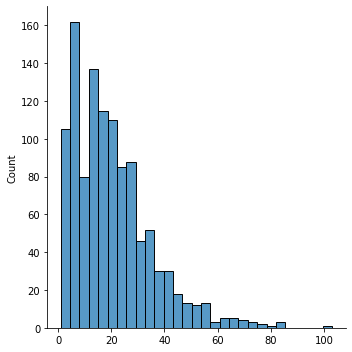

In [36]:
#sns.displot(data=penguins, x="flipper_length_mm", kind="kde")
#sns.displot(data=len_train, kind="kde")
sns.displot(x=len_train, )

In [67]:
from random import shuffle
arab_plot = arab_sents[:700]
shuffle(arab_plot)  # randomizes in place


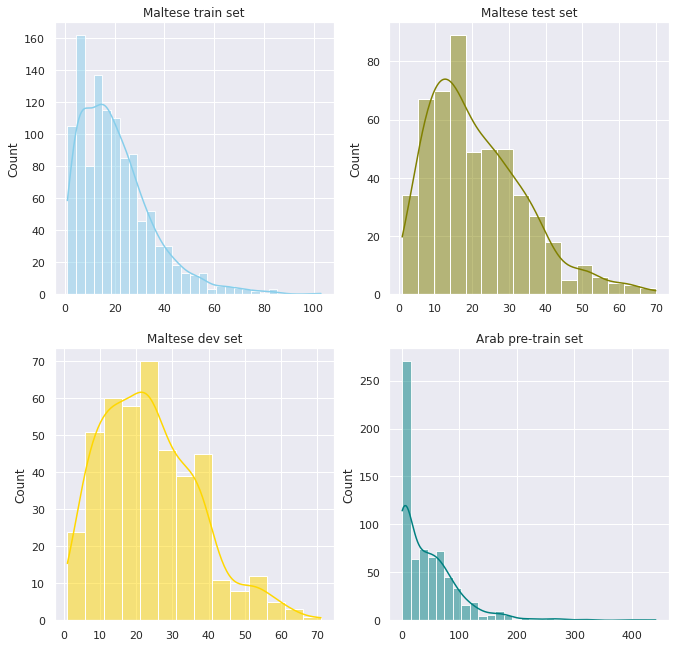

In [72]:


sns.set(style="darkgrid")


fig, axs = plt.subplots(2, 2, figsize=(11, 11))

sns.histplot(data=len_train, kde=True, color="skyblue", ax=axs[0, 0]).set(title='Maltese train set')
sns.histplot(data=len_test, kde=True, color="olive", ax=axs[0, 1]).set(title='Maltese test set')
sns.histplot(data=len_dev, kde=True, color="gold", ax=axs[1, 0]).set(title='Maltese dev set')
sns.histplot(data=[len(sentence) for sentence in arab_plot], kde=True, color="teal", ax=axs[1, 1]).set(title='Arab pre-train set')

plt.show()

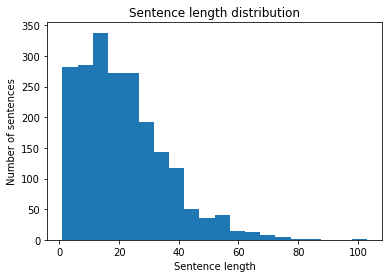

max length: 103


In [14]:
from matplotlib import pyplot as plt

# compute and show histogram for sentence length
plt.hist([len(sentence) for sentence in all_tokens], 20)
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Sentence length distribution')
plt.show()

# compute max sentence length
print('max length:', max([len(sentence) for sentence in all_tokens]))

# Arabic sentence

In [41]:
corpus = base_path + f'/Languages/{lang}/Corpora/{lang}_corpus.txt'
corpus = f'./Languages/arabic/Corpora/arabic_corpus.txt'

In [42]:
with open(corpus, 'r') as f:
  stored = f.readlines()

In [43]:
@dataclass
# 1. We take in a sentence and its tags
# 2. We tokenize the sentence using the tokenizer
# 3. We create a list of tags for each word in the sentence
# 4. We create a list of tags for each token in the sentence
# 5. We create a list of tags for each subtoken in the sentence
# 6. We return a dictionary of the tokenized sentence, the list of tags for each word, and the list of
# tags for each subtoken
class PreArabDataCollator:
    
    def __init__(self, tokenizer, max_len):

        self.tokenizer = tokenizer
        self.max_len = max_len        
        
    
    def __call__(self, batch):
        
        input_ids = []
        attention_mask = []
        labels = []
        
        for sent in batch['sents']:  # was sentences before
            
            tokenized = self.tokenize(sent)
            input_ids.append(tokenized['input_ids'])
            attention_mask.append(tokenized['attention_mask'])            
            
        
        
        batch = {'input_ids':input_ids,'attention_mask':attention_mask}
        

        return batch

    def tokenize(self, sentence):
        
  

        # using tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides "return_offsets_mapping" functionality for individual tokens, so we know the start and end of a token divided into subtokens
        encoding = self.tokenizer(sentence,                             
                             #return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
 
            

        # turning everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}        

        return item


In [46]:
#MAX_LEN = 128
arab_data = Dataset.from_dict({"sents": stored})
collator = PreArabDataCollator(tokenizer=tokenizer, max_len=MAX_LEN)
arab_tokenized = arab_data.map(collator, remove_columns=arab_data.column_names, batch_size=4, num_proc=4, batched=True)


Map (num_proc=4):   0%|          | 0/70000 [00:00<?, ? examples/s]

In [47]:
arab_data['sents'][0]

"kan alfylswf alywnany iymbydwklys awl mn qdm mfhwm nzrya al'nasr alarb'a alty ytkwn mnha al'alm, walty sadt lftra twyla mn alzmn. t'tmd alnzrya 'la arb'a mwad why alma' walnar walhwa' waltrab. ama fy nzrya alakhlat alarb'a faqtrn alma' m' alblghm bkwnh bardan wrtban. kan alma' aydan mn al'nasr altqlydya fy nzrya al'nasr alkhmsa hsb alflsfa alsynya altqlydya, wthlk balidafa ila alnar waltrab walm'dn walkhshb. kma an alma' ydkhl fy al'dyd mn alflsfat walm'tqdat mthl altawya, hyth drb bh almthl fy ktab dawdyjngh bjm'h lladdad kyf anh d'yf wryeyf fy hyn; wkyf anh qwy wshdyd fy hyn akhr.\n"

In [48]:
for i in arab_data['sents']:
    print(i)
    print(len(i.split()))
    break

kan alfylswf alywnany iymbydwklys awl mn qdm mfhwm nzrya al'nasr alarb'a alty ytkwn mnha al'alm, walty sadt lftra twyla mn alzmn. t'tmd alnzrya 'la arb'a mwad why alma' walnar walhwa' waltrab. ama fy nzrya alakhlat alarb'a faqtrn alma' m' alblghm bkwnh bardan wrtban. kan alma' aydan mn al'nasr altqlydya fy nzrya al'nasr alkhmsa hsb alflsfa alsynya altqlydya, wthlk balidafa ila alnar waltrab walm'dn walkhshb. kma an alma' ydkhl fy al'dyd mn alflsfat walm'tqdat mthl altawya, hyth drb bh almthl fy ktab dawdyjngh bjm'h lladdad kyf anh d'yf wryeyf fy hyn; wkyf anh qwy wshdyd fy hyn akhr.

97


In [49]:
for i in arab_tokenized['input_ids']:
    print(len(i))
    decoding = tokenizer.decode(i, skip_special_tokens=True).split()
    print(decoding)
    print(len(decoding))
    break

256
['kan', 'alfylswf', 'alywnany', 'iymbydwklys', 'awl', 'mn', 'qdm', 'mfhwm', 'nzrya', "al'nasr", "alarb'a", 'alty', 'ytkwn', 'mnha', "al'alm,", 'walty', 'sadt', 'lftra', 'twyla', 'mn', 'alzmn.', "t'tmd", "alnzrya'la", "arb'a", 'mwad', 'why', "alma'walnar", "walhwa'waltrab.", 'ama', 'fy', 'nzrya', 'alakhlat', "alarb'a", 'faqtrn', "alma'm'alblghm", 'bkwnh', 'bardan', 'wrtban.', 'kan', "alma'aydan", 'mn', "al'nasr", 'altqlydya', 'fy', 'nzrya', "al'nasr", 'alkhmsa', 'hsb', 'alflsfa', 'alsynya', 'altqlydya,', 'wthlk', 'balidafa', 'ila', 'alnar', 'waltrab', "walm'dn", 'walkhshb.', 'kma', 'an', "alma'ydkhl", 'fy', "al'dyd", 'mn', 'alflsfat', "walm'tqdat", 'mthl', 'altawya,', 'hyth', 'drb', 'bh', 'almthl', 'fy', 'ktab', 'dawdyjngh', "bjm'h", 'll']
77


In [50]:
arab_sents = [sent.split() for sent in arab_data['sents']]

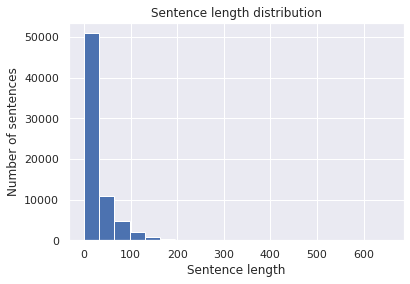

max length: 653


In [52]:
plt.hist([len(sentence) for sentence in arab_sents], 20)
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Sentence length distribution')
plt.show()

# compute max sentence length
print('max length:', max([len(sentence) for sentence in arab_sents]))

In [ ]:
maltese_corpus.txt